In [1]:
!unzip /content/house-price-prediction-cpe-232-data-models.zip

Archive:  /content/house-price-prediction-cpe-232-data-models.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


# RandomForest Solution 1

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load the data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [4]:
# Function for comprehensive data exploration
def explore_data(df, title):
    print(f"\n{title} Data Shape: {df.shape}")
    print("\nFirst 5 rows:")
    print(df.head())
    print("\nData Types and Missing Values:")
    print(df.info())
    print("\nDescriptive Statistics:")
    print(df.describe())
    print("\nMissing Values:")
    print(df.isnull().sum())

In [5]:
# Explore the training data
explore_data(train_data, "Training")


Training Data Shape: (24997, 18)

First 5 rows:
   id  squareMeters  numberOfRooms  hasYard  hasPool  floors  cityCode  \
0   0       63396.0            NaN      NaN      1.0    51.0   68952.0   
1   1       81451.0           26.0      0.0      1.0    67.0   82251.0   
2   2       34272.0           53.0      1.0      1.0     6.0    2842.0   
3   3       89263.0           41.0      0.0      0.0    45.0       NaN   
4   4       88018.0           40.0      1.0      1.0    95.0   12877.0   

   cityPartRange  numPrevOwners    made  isNewBuilt  hasStormProtector  \
0            NaN            2.0  2014.0         0.0                1.0   
1           10.0            NaN  2013.0         0.0                1.0   
2            9.0            9.0  1997.0         0.0                1.0   
3            1.0            2.0  1999.0         0.0                0.0   
4            4.0            2.0  2018.0         NaN                1.0   

   basement    attic  garage  hasStorageRoom  hasGuestRoom   

In [6]:
# Create a copy for cleaning and preprocessing
train = train_data.copy()
test = test_data.copy()

In [7]:
# Check for duplicates
print(f"\nDuplicates in training data: {train.duplicated().sum()}")


Duplicates in training data: 0


In [8]:
# Feature Engineering
def preprocess_data(df):
    # Create a copy to avoid modifications to original
    df = df.copy()

    # Handle missing values (if any)
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            if df[col].dtype == 'object':
                df[col] = df[col].fillna(df[col].mode()[0])
            else:
                df[col] = df[col].fillna(df[col].median())

    # Calculate age of house
    df['houseAge'] = 2025 - df['made']

    # Calculate total extra area
    df['totalExtraArea'] = df['basement'] + df['attic'] + df['garage']

    # Calculate room density
    df['roomDensity'] = df['numberOfRooms'] / df['squareMeters']

    # Create a premium features count
    df['premiumFeatures'] = df['hasYard'] + df['hasPool'] + df['hasStormProtector'] + \
                           df['hasStorageRoom'] + df['hasGuestRoom']

    return df

In [9]:
# Apply preprocessing
train = preprocess_data(train)
test = preprocess_data(test)

In [10]:
# Visualize relationships between features and target
def visualize_relationships(df):
    plt.figure(figsize=(12, 10))

    # Create a correlation matrix
    correlation = df.corr()
    mask = np.triu(np.ones_like(correlation, dtype=bool))
    sns.heatmap(correlation, mask=mask, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.show()

    # Top features correlation with price
    plt.figure(figsize=(10, 8))
    price_correlation = correlation['price'].sort_values(ascending=False)
    sns.barplot(x=price_correlation.values[1:11], y=price_correlation.index[1:11])
    plt.title('Top 10 Features Correlated with Price')
    plt.tight_layout()
    plt.show()

In [11]:
# Prepare data for modeling
def prepare_model_data(df, target_available=True):
    # Separate features
    if target_available:
        X = df.drop(['id', 'price'], axis=1)
        y = df['price']
        return X, y
    else:
        X = df.drop(['id'], axis=1)
        return X

In [12]:
# Split training data into training and validation sets
X_train, y_train = prepare_model_data(train)
X_test = prepare_model_data(test, target_available=False)

In [13]:
# Further split training data for validation
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

In [14]:
# Define preprocessor pipeline
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)


In [15]:
# Create a pipeline with preprocessing and Random Forest
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

In [16]:
# Define hyperparameters for grid search
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

In [17]:
# Uncomment for full hyperparameter tuning (this can take time)
# grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
# grid_search.fit(X_train, y_train)
# best_params = grid_search.best_params_
# print(f"Best parameters: {best_params}")
# best_model = grid_search.best_estimator_

# For now, use a simplified model with some reasonable parameters
rf_model = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    ))
])

# Train the model
rf_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['squareMeters',
                                                   'numberOfRooms', 'hasYard',
                                                   'hasPool', 'floors',
                                                   'cityCode', 'cityPartRange',
                                                   'numPrevOwners', 'made',
                                                   'isNewBuilt',
                                                   'hasStormProtector',
                                                   'basement', 'attic',
                                                   'garage', 'hasStorageRoom',
                                                   'hasGuestRoom', 'houseAge',
                                                   'totalExtraArea',
                                                   'roomDensity',
                                                   'premiumFeatures']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  [])])),
                ('model',
                 RandomForestRegressor(max_depth=20, min_samples_leaf=2,
                                       min_samples_split=5, n_estimators=200,
                                       random_state=42))])

In [18]:
# Evaluate on validation data
y_val_pred = rf_model.predict(X_val)

In [19]:
# Evaluate the model
def evaluate_model(y_true, y_pred, title="Model Performance"):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{title}:")
    print(f"Mean Absolute Error (MAE): {mae:,.2f}")
    print(f"Mean Squared Error (MSE): {mse:,.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:,.2f}")
    print(f"R² Score: {r2:.4f}")

    # Visualize prediction vs actual
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title('Actual vs Predicted House Prices')
    plt.tight_layout()
    plt.show()

    # Visualize residuals
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Price')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.tight_layout()
    plt.show()


Validation Set Performance:
Mean Absolute Error (MAE): 163,324.58
Mean Squared Error (MSE): 299,338,311,340.65
Root Mean Squared Error (RMSE): 547,118.19
R² Score: 0.9647


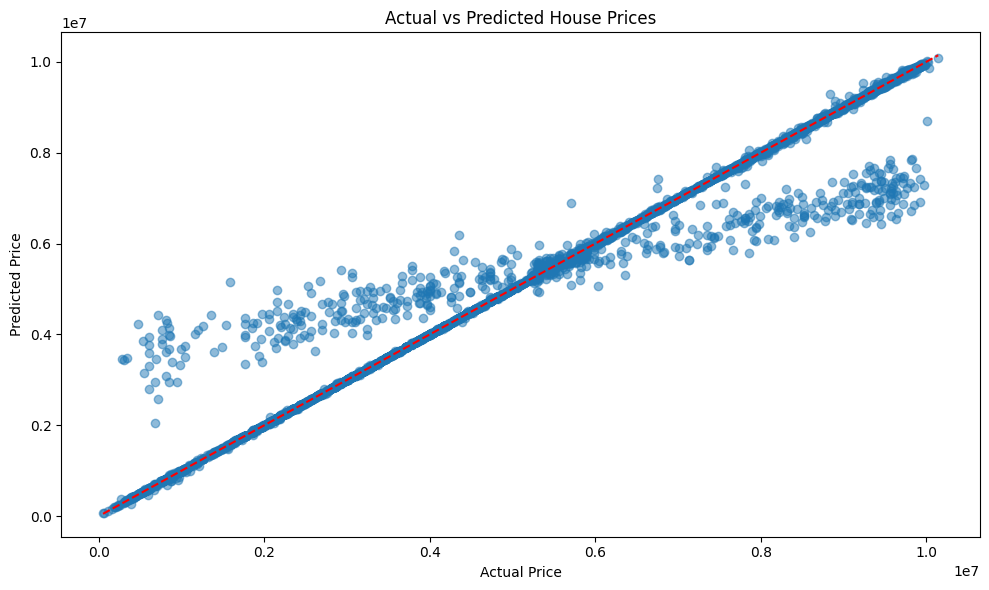

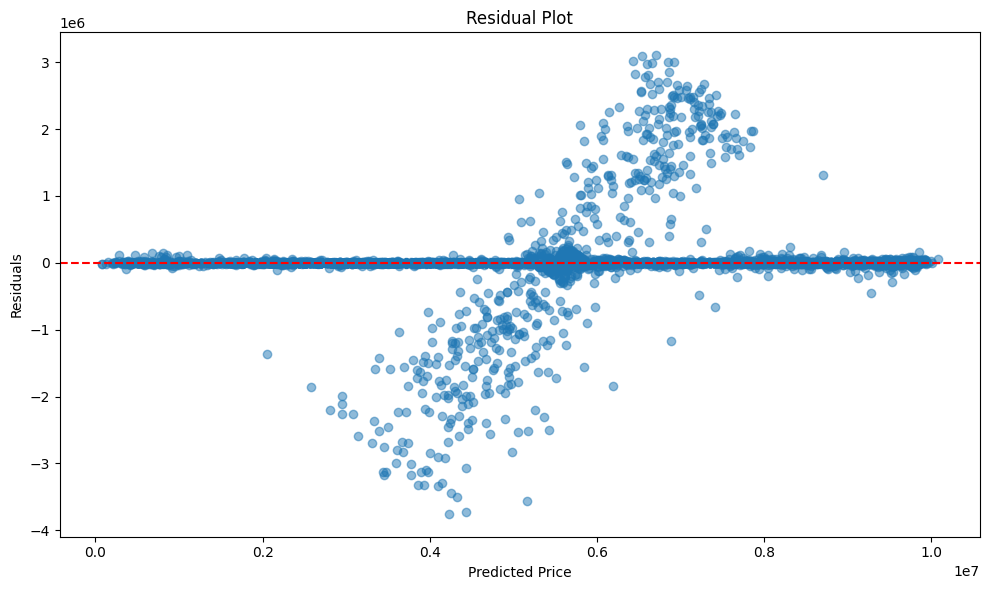

In [20]:
# Evaluate on validation set
evaluate_model(y_val, y_val_pred, "Validation Set Performance")

# Feature importance
def plot_feature_importance(model, X):
    # Get feature importance from the model
    feature_names = X.columns
    feature_importance = model.named_steps['model'].feature_importances_

    # Create DataFrame for better visualization
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values(by='Importance', ascending=False)

    # Plot
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
    plt.title('Random Forest Feature Importance')
    plt.tight_layout()
    plt.show()

    return importance_df

In [ ]:
# importance_df = plot_feature_importance(rf_model, X_train)
# print(importance_df.head(15))

In [21]:
# Cross-validation for more robust evaluation
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_mae = -cv_scores.mean()
print(f"\nCross-validation MAE: {cv_mae:,.2f}")


Cross-validation MAE: 299,255.38


In [22]:
# Make predictions on the test set
test_predictions = rf_model.predict(X_test)

In [23]:
# Create submission file
submission = pd.DataFrame({
    'id': test_data['id'],
    'price': test_predictions
})

# Save submission file
submission.to_csv('random_forest_submission_1.csv', index=False)
print("\nSubmission file created!")

# Display the first few rows of the submission file
print(submission.head())


Submission file created!
      id         price
0  24997  4.935965e+06
1  24998  5.022639e+06
2  24999  5.771476e+06
3  25000  9.474619e+06
4  25001  9.151412e+06


# RandomForest Solution 2

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Load data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Separate features and target
X = train_data.drop(['id', 'price'], axis=1)
y = train_data['price']
test_ids = test_data['id']
X_test = test_data.drop('id', axis=1)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
def add_features(df):
    # Age of the house
    df['houseAge'] = 2025 - df['made']

    # Total area (main + basement + attic + garage)
    df['totalArea'] = df['squareMeters'] + df['basement'] + df['attic'] + df['garage']

    # Room density
    df['roomDensity'] = df['numberOfRooms'] / df['squareMeters']

    # Has both yard and pool
    df['hasYardPool'] = (df['hasYard'] == 1) & (df['hasPool'] == 1)

    return df

X_train = add_features(X_train)
X_val = add_features(X_val)
X_test = add_features(X_test)

In [4]:
# Convert categorical columns (if any need special treatment)
# For Random Forest, we can often leave categoricals as is if they're already encoded
categorical_cols = ['cityCode', 'cityPartRange', 'isNewBuilt', 'hasYard', 'hasPool',
                   'hasStormProtector', 'hasStorageRoom', 'hasGuestRoom']

for col in categorical_cols:
    X_train[col] = X_train[col].astype('category')
    X_val[col] = X_val[col].astype('category')
    X_test[col] = X_test[col].astype('category')

In [5]:
# Initialize model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Train model
rf.fit(X_train, y_train)

# Make predictions
val_preds = rf.predict(X_val)

# Evaluate
mae = mean_absolute_error(y_val, val_preds)
print(f"Initial MAE: {mae:,.2f}")

Initial MAE: 281,359.49


In [ ]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Initialize grid search
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    scoring='neg_mean_absolute_error',
    verbose=2
)

# Fit grid search
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)

# Best model
best_rf = grid_search.best_estimator_

# Evaluate on validation set
val_preds = best_rf.predict(X_val)
mae = mean_absolute_error(y_val, val_preds)
print(f"Optimized MAE: {mae:,.2f}")

Fitting 3 folds for each of 216 candidates, totalling 648 fits


In [ ]:
import matplotlib.pyplot as plt

# Get feature importances
importances = best_rf.feature_importances_
feature_names = X_train.columns

# Create DataFrame
feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot
plt.figure(figsize=(12, 8))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# Combine train and validation sets for final training
X_full = pd.concat([X_train, X_val])
y_full = pd.concat([y_train, y_val])

# Train final model with best parameters
final_model = RandomForestRegressor(**grid_search.best_params_, random_state=42)
final_model.fit(X_full, y_full)

# Predict on test set
test_preds = final_model.predict(X_test)

# Create submission file
submission = pd.DataFrame({'id': test_ids, 'price': test_preds})
submission.to_csv('random_forest_submission_2.csv', index=False)